----
## C.6 sklearn

### 데이터

In [1]:
import numpy as np

X = np.array([[2,5],[3,6],[2,4],[5,7],[7,2],[8,3],[9,4],[8,4],[7,3]], dtype = float)

### k-means 클러스터링

* n_clusters=2, 클러스터를 2개로 설정,
* ```init='random'```은 초기화를 무작위로 설정,
* ```random_state=2```에 정수를 입력하면, 그 정수는 중심값을 무작위로 생성하는 seed로 쓰인다. seed를 정하게 되면, 클러스터링을 몇 번 해도 동일한 결과가 만들어질 수 있다.

In [2]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='random', random_state=2).fit(X) #씨드번호는 정수로

### 클러스터 할당

각 데이터 항목에게 배정된 클러스터를 출력하면, 앞서의 결과와 동일하다.

In [3]:
print ("Cluster label: ", kmeans.labels_)

Cluster label:  [0 0 0 0 1 1 1 1 1]


클러스터의 중심점을 출력해보자.

In [4]:
print ("Centroid: ", kmeans.cluster_centers_)

Centroid:  [[3.  5.5]
 [7.8 3.2]]


### 예측

두 점을 입력하고, 어느 클러스터에 할당되는지 예측해볼 수 있다.

In [5]:
print ("Predictions: ", kmeans.predict([[0, 0], [7, 4]]))

Predictions:  [0 1]


## 문제: sklearn 클러스터링

In [6]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2],[1, 4],[1, 0],[4, 2],[4, 4],[4, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print ("Cluster label: ", kmeans.labels_)
print ("Centroid: ", kmeans.cluster_centers_)
print ("Predictions: ",kmeans.predict([[0, 0], [4, 4]]))

Cluster label:  [1 0 1 0 0 1]
Centroid:  [[3.         3.33333333]
 [2.         0.66666667]]
Predictions:  [1 0]


## C.7 Spark

Python 실행경로를 지정해주고, SparkSession을 먼저 생성하자.

In [7]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

### 데이터 생성

numpy 배열 데이터를 생성해보자. 2개의 속성으로 구성된 배열을 2차원으로 가지고 있다.

In [8]:
import numpy as np

x = np.array([[2,5],[3,6],[2,4],[5,7],[7,2],[8,3],[9,4],[8,4],[7,3]], dtype = float)

### DataFrame

Numpy array와 Spark Dataframe은 서로 다른 구조를 가지고 있으며, 데이터타입도 서로 다르다.
numpy array는 Pandas를 통하거나, RDD로 만든 후, DataFrame으로 변환해준다.
여기서는 RDD를 통해서 DataFrame으로 만들기로 하자.

In [9]:
_xRdd = spark.sparkContext.parallelize(x)

Rdd는 컬럼명이나 데이터타입을 설정하지 않고 만들었다.
데이터를 정수형으로 변환해주자.

In [10]:
xRdd = _xRdd.map(lambda x: [int(i) for i in x])

데이터가 올바르게 읽혀졌는지 collect() 해보자.

In [11]:
xRdd.collect()

[[2, 5], [3, 6], [2, 4], [5, 7], [7, 2], [8, 3], [9, 4], [8, 4], [7, 3]]

이제 DataFrame으로 변환하자. 컬럼명은 같이 리스트 ```["x", "y"]```로 입력해준다.

In [15]:
xDf = xRdd.toDF(["x", "y"])
xDf.show()

+---+---+
|  x|  y|
+---+---+
|  2|  5|
|  3|  6|
|  2|  4|
|  5|  7|
|  7|  2|
|  8|  3|
|  9|  4|
|  8|  4|
|  7|  3|
+---+---+



### Features 설정

클러스터링에 쓰이게 될 속성을 ```VectorAssembler```로 묶어서 ```features``` 컬럼을 생성해주자.

In [16]:
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler #df니까 ml

va = VectorAssembler(inputCols=["x","y"],outputCol="features")  #spark는 벡터로 만들어서 실행해야한다

```VectorAssembler```를 적용한다.

In [17]:
xxDf = va.transform(xDf)

In [18]:
xxDf.printSchema()

root
 |-- x: long (nullable = true)
 |-- y: long (nullable = true)
 |-- features: vector (nullable = true)



In [19]:
xxDf.show(5) #여기선 dense vector

+---+---+---------+
|  x|  y| features|
+---+---+---------+
|  2|  5|[2.0,5.0]|
|  3|  6|[3.0,6.0]|
|  2|  4|[2.0,4.0]|
|  5|  7|[5.0,7.0]|
|  7|  2|[7.0,2.0]|
+---+---+---------+
only showing top 5 rows



### k-means 클러스터링

mllib, ml 모두 KMeans 모델을 지원한다.
* k를 몇 개, 어떻게 정할지 설정한다.

클러스터의 수 k=1로 하고 k-means를 실행해보자.

In [20]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2)

In [21]:
model = kmeans.fit(xxDf) #features frame이 있는 xxDf에 fit시킨다.

### 클러스터 중심점

In [22]:
print (model.clusterCenters())

[array([7.8, 3.2]), array([3. , 5.5])]


## 문제: iris 데이터 클러스터링

iris는 꽃잎 및 꽃받침의 너비와 높이 데이터이다.
이 데이터를 군집화 해보자.

### 데이터

iris 데이터는 seaborn, sklearn 등 많은 패키지에서 내장해서 제공되고 있다.

In [23]:
from sklearn import datasets

dataset = datasets.load_iris()

sklearn에서 제공하는 데이터는 타입이 다르기 때문에, 바로 사용할 수 없고 변환을 해야 한다.
```sklearn.utils.Bunch```라고 하는 타입으로 저장되어 있는데, 이는 **Dictionary 타입**이라서 아래와 같은 키를 입력하여 읽을 수 있다.
* 'data': numpy.array로 저장된 속성 데이터
* 'target': numpy.array로 저장된 분류 데이터
* 'target_names': numpy.array로 저장된 분류 값 ['setosa', 'versicolor', 'virginica']
* 'DESCR': 데이터 관련한 설명
* 'feature_names': ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

```dataset['data']```는 numpy array 타입이다. 데이터를 읽어보자.

In [24]:
data = dataset['data']

인덱스 ```1:5```, 즉 1부터 4까지, 4행을 읽어보자.

In [25]:
data[1:5]

array([[4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

### 그래프

변수가 4개이므로, 4차원 그래프를 그려야 맞다.
그렇게 되면 명령어가 복잡해지므로, 3차원으로 그래프를 그려보자.
gca(projection='3d')라고 해주면 된다.

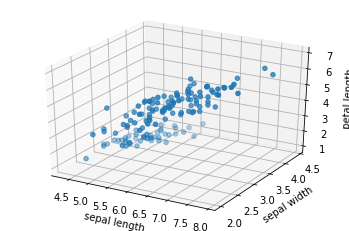

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure().gca(projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2]) #x,y,z
ax.set_xlabel('sepal length')
ax.set_ylabel('sepal width')
ax.set_zlabel('petal length')
plt.show()

### RDD 생성

numpy array는 바로 RDD를 생성할 수 있다. df로 가려면 바로 못가고 rdd에서 바꿔줘야함

In [31]:
_xRdd = spark.sparkContext.parallelize(data)

In [32]:
_xRdd.take(1)

[array([5.1, 3.5, 1.4, 0.2])]

### 형변환

앞서 보듯이 numpy.array에 생성되었으므로, array로 구성되어 있다. 이를 소수배열로 변환하자.

In [33]:
xRdd = _xRdd.map(lambda x: [float(i) for i in x])

In [34]:
xRdd.take(1)

[[5.1, 3.5, 1.4, 0.2]]

### k-Means 모델링

mllib 라이브러리의 KMeans 모델을 

```python
KMeanstrain(rdd, k, maxIterations=100, initializationMode='k-means', seed=None, initializationSteps=2, epsilon=0.0001, initialModel=None)
```

* rdd: RDD 훈련데이터
* k: 클러스터 갯수
* maxIterations: 최대 반복횟수 (기본 값: 100)
* initializationMode: 초기 알고리즘 "random" 또는 "k-means" (기본 값)
* seed: 클러스터 초기화에 필요한 무작위 seed 값 (default는 None (시스템시간에서 seed를 만드는 방식))
* initializationSteps: k-means 단계 수 (기본 값: 2)
* epsilon: 클러스터 중심값이 이 값이 이하로 움직이면 거리 임계값 (기본 값: 1e-4)
* initialModel: 초기 클러스터 중심값 (기본 값: None)

In [35]:
from pyspark.mllib.clustering import KMeans

model = KMeans.train(xRdd, k = 2, maxIterations = 10)

클러스터의 중심값을 출력해보자. k=2로 설정해 놓아서, 2개의 중심값이 출력된다.

In [36]:
model.clusterCenters

[array([6.30103093, 2.88659794, 4.95876289, 1.69587629]),
 array([5.00566038, 3.36981132, 1.56037736, 0.29056604])]

이 경우의 오류를 계산해보자.

In [37]:
model.computeCost(xRdd)

152.34795176035803

from math import sqrt
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

### DataFrame 생성

이번에는 DataFrame으로 k-Means 클러스터링을 해보자.  
앞서 상관관계를 계산하면서 사용했듯이, url으로부터 iris를 읽어보자.  

바로 읽어보기 위해서 pandas 이용한다

In [39]:
file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

Spark DataFrame은 url에서 읽어서 생성할 수 없으므로, Pandas로 먼저 읽자.

In [40]:
import pandas as pd

iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [41]:
irisDf = spark.createDataFrame(iris)

### 통계량

데이터는 모두 150개로 결측 값이 없다.
petal_length가 다른 측정값에 비해 표준편차가 다소 크다.
최대, 최소 값으로 추정하면, 그 측정 값이 다소 퍼져 있다는 것을 알 수 있다.
그러나 표준편차 2배 이상인 경우는 많지 않아 보인다.

In [42]:
irisDf.describe().show()

+-------+------------------+-------------------+------------------+------------------+--------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|       species|
+-------+------------------+-------------------+------------------+------------------+--------------+
|  count|               150|                150|               150|               150|           150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|          null|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|          null|
|    min|               4.3|                2.0|               1.0|               0.1|   Iris-setosa|
|    max|               7.9|                4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+-------------------+------------------+------------------+--------------+



### features 생성(넘어감..)

Vector assembler는 변수를 묶어서 하나의 Vector로 만들어 준다.

In [43]:
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler #4개 속성을 vector로 묶기 위함

va = VectorAssembler(inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"], outputCol="features")
xxDf = va.transform(irisDf)

features 컬럼이 vector로 만들어진 것을 확인해보자.

In [44]:
xxDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)
 |-- features: vector (nullable = true)



In [45]:
xxDf.show(3)

+------------+-----------+------------+-----------+-----------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|
+------------+-----------+------------+-----------+-----------+-----------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|
+------------+-----------+------------+-----------+-----------+-----------------+
only showing top 3 rows



입력데이터의 타입이 명목일수도 아닐 수도 있는 모르는 경우, Vector Indexer는 이 가운데 범주형 변수를 가려내어 Vector로 만든다. 참고로 String Indexer는 명목변수 컬럼을 인덱스 값으로 변환한다. 요일을 1~7 값으로 변환하는 경우를 예로 들 수 있다.

In [46]:
from pyspark.ml.feature import VectorIndexer

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="featuresIndexed",\
                               maxCategories=4).fit(xxDf)
xxxDf = featureIndexer.transform(xxDf)

In [47]:
xxxDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- featuresIndexed: vector (nullable = true)



In [48]:
xxxDf.show(5)

+------------+-----------+------------+-----------+-----------+-----------------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|  featuresIndexed|
+------------+-----------+------------+-----------+-----------+-----------------+-----------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-----------+-----------------+-----------------+
only showing top 5 rows



### k-Means

features, featuresIndexed 어느 것으로 해도 결과는 동일하다.

kMeans 모델은 앞서 RDD에서와 같이 초기 값을 설정할 수 있다.
```python
(featuresCol='features', predictionCol='prediction', k=2, initMode='k-means', initSteps=2, tol=0.0001, maxIter=20, seed=None, distanceMeasure='euclidean', weightCol=None)
```
* maxIter: 클러스터를 분할하기 위한 최대 반복 횟수 (default: 20)


set함수를 이용해서 다음과 같이 할 수 있다.
```python
kmeans = KMeans()\
        .setK(k)\
        .setSeed(1) \
        .setFeaturesCol("indexedFeatures")\
        .setPredictionCol("cluster")
```

In [49]:
from pyspark.ml.clustering import KMeans

# features라는 이름을 안쓸 경우 반드시 setFeaturesCol 통해서 설정해줘야한다.
kmeans = KMeans(k=2) \
            .setFeaturesCol("features") \
            .setPredictionCol("cluster")

In [50]:
model = kmeans.fit(xxDf)

In [51]:
print (model.clusterCenters())

[array([6.30103093, 2.88659794, 4.95876289, 1.69587629]), array([5.00566038, 3.36037736, 1.56226415, 0.28867925])]


In [52]:
model.transform(xxDf).show()

+------------+-----------+------------+-----------+-----------+-----------------+-------+
|sepal_length|sepal_width|petal_length|petal_width|    species|         features|cluster|
+------------+-----------+------------+-----------+-----------+-----------------+-------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|      1|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|      1|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|      1|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|      1|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|      1|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|[5.4,3.9,1.7,0.4]|      1|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|[4.6,3.4,1.4,0.3]|      1|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|[5.0,3.4,1.5,0.2]|      1|
|         

### 최적의 클러스터 갯수

클러스터 분석에 있어, 최적의 갯수를 결정할 필요가 있는데, elbow, silhouette 그리고 gap statistic 방법이 있다.
elbow 방법은 클러스터의 개수를 결정하는 직관적 방법이다.
오류를 계산하고, 그래프를 그려서 클러스터 개수를 늘려도 그 오류의 기울기가 줄어드는 지점,
즉 추세가 꺽이는, 팔꿈치가 접히는 지점이 적당한 개수로 인식하게 된다.

Silhouette은 계수로 클러스터링 적합도를 측정한다. 계수는 -1 ~ 1 값을 가진다.
* 1: 클러스터가 서로 잘 분리되어 있다는 의미
* 0: 클러스터가 서로 차이가 없다는 의미. 클러스터 간의 거리가 유의미하지 않다
* -1: 클러스터에 할당된 데이터가 올바르지 못하다는 의미.

In [53]:
from pyspark.ml.evaluation import ClusteringEvaluator
#silhouette = np.zeros(15)
silhouetteList = list()
for i in range(2, 17): #시작값 1은 의미없음, 끝값은 적당히
    # Trains a k-means model.
    kmeans = KMeans().setK(i).setFeaturesCol("features")
    model = kmeans.fit(xxDf)
    # Evaluate clustering by computing Within Set Sum of Squared Errors
    predictions = model.transform(xxxDf)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator().setMetricName("silhouette") #클러스터의 정확도 평가
    silhouette = evaluator.evaluate(predictions) 
    #silh_val.append(silhouette)
    print("...{} Within Set Sum of Squared Errors {}".format(i, silhouette)) # 오류 제곱의 합
    silhouetteList.append(silhouette)

...2 Within Set Sum of Squared Errors 0.8501515983265806
...3 Within Set Sum of Squared Errors 0.7342113066202725
...4 Within Set Sum of Squared Errors 0.6720731409257744
...5 Within Set Sum of Squared Errors 0.6693502650358714
...6 Within Set Sum of Squared Errors 0.6501188133610175
...7 Within Set Sum of Squared Errors 0.6427205254298456
...8 Within Set Sum of Squared Errors 0.5899234507766099
...9 Within Set Sum of Squared Errors 0.5059433092289696
...10 Within Set Sum of Squared Errors 0.4519423528557159
...11 Within Set Sum of Squared Errors 0.4736965793161545
...12 Within Set Sum of Squared Errors 0.46023251596117487
...13 Within Set Sum of Squared Errors 0.3769126933676903
...14 Within Set Sum of Squared Errors 0.41890183515370105
...15 Within Set Sum of Squared Errors 0.4232404679172925
...16 Within Set Sum of Squared Errors 0.4221172445104842


### 클러스터 갯수에 따른 오류의 그래프

그래프를 읽을 때, 클러스터의 갯수가 2개부터 시작한다는 점에 유의하자.
클러스터의 갯수가 2일 경우, 계수가 제일 높다.

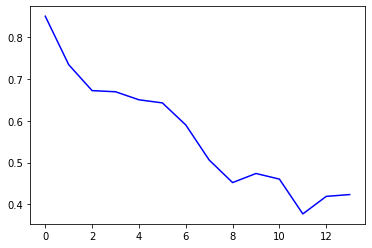

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.arange(14), silhouetteList[0:14], color='blue') #위에서는 2부터 시작하니까 여기서 0이 클러스터 2라고 생각하면 된다.